In [1]:
import numpy as np
import scipy as sc
import scipy.constants as cn
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

#from qutip import *
#from tucpler import *

# 可调耦合器中的超导量子比特参数设计

参数设计考虑两个方面：一个是工艺上的限制，另一个是功能上的限制。超导比特基于非线性谐振子制成，。参数对比特进行限制，工艺决定了比特的优劣，。

#### 设计流程总结：
* 非谐 -> 确定量子比特的电容
* 由量子比特的频率结合非谐 -> 确定 $\frac{E_J}{E_C}$ 的比值 -> 根据SQUID的类型确定两个约瑟夫森结的常温电阻
* 超导量子比特之间的耦合 -> 根据可调耦合强度的调节范围确定耦合电容的大小和可调耦合器参数(若以保真度为优先条件，这一步不需要)
* 考虑 Coupler 的频率范围 -> 确定 Coupler 的 $\frac{E_J}{E_C}$ -> 根据SQUID的类型确定两个约瑟夫森结的常温电阻

* 读出谐振腔的频率和超导量子比特之间的耦合强度 -> 确定读出谐振腔与超导量子比特之间的耦合电容
* 读出谐振腔的耗散和读出谐振腔的频率 -> 确定读出谐振腔与总线之间的耦合电容和读出谐振腔的外品质因子


上述是一般比特设计的流程。加入了可调耦合器以后，要优先考虑双比特门的实现。为了达到高保真度，比特、Coupler 的设计参数都是事先通过优化过程选择好的。当然，会在设计参数的限制下进行选择。此时打开点与关断点已经确定，可以直接算出对应的比特间有效耦合强度。

接着要考虑比特频率范围、耦合器频率范围(其中包括了耦合器调节范围)、腔频点，这三个范围不能重合，并且要有足够间距。

最后要考虑同时实现单比特门与双比特门，此时比特频率变动会导致开关点变动，即耦合器调节范围，这个变动不能超出耦合器本身的频率范围。

### 电容的确定

In [2]:
# 电容与非谐的互换
def c_to_eta(C):
    '''Transfer capacity to the corresponding anharmonicity'''
    eta = -cn.e**2/(2 * cn.h * C *1e6)*1e15
    return round(eta)
    
def eta_to_c(eta):
    '''Transfer anharmonicity to the corresponding capacity'''
    C = -cn.e**2/(2*cn.h*eta*1e6)*1e15
    return C

非谐范围限制由经验确定, 为 -220 ~ -260 MHz，对应比特电容上下限如下：

In [3]:
Cmin, Cmax = eta_to_c(-220), eta_to_c(-260)
print(int(Cmin), int(Cmax))

88 74


由优化结果确定比特电容为 86fF

In [4]:
C1, C2 = 86, 86
eta1, eta2 = c_to_eta(C1), c_to_eta(C2)

In [5]:
eta1, eta2

(-225, -225)

### 量子比特频率结合非谐确定SQUID参数

首先明确，量子比特频率指的是非线性谐振子的10能级差，为了不与其他频率混淆，用 $\omega_{10}$ 表示。

$$
\omega_{10} = \frac{\sqrt{8 E_{J}E_{C}}-E_{C}}{\hbar}
$$
其中 $E_{C} = \frac{e^{2}}{2C}$。对于单结，$E_{J} = \frac{I_{c} \Phi_{0}}{2\pi}$。对于双结即 SQUID，该式改为：

$$
E_{J} = (E_{j1}+E_{j2})cos\left(\pi\frac{\Phi_{c}}{\Phi_{0}}\right)\sqrt{ 1+d^{2}tan^{2}\left(\pi\frac{\Phi_{c}}{\Phi_{0}}\right) }
$$
其中 $d=\frac{E_{j1}-E_{j2}}{E_{j1}+E_{j2}}$ 为不对称度，$E_{j1}$和$E_{j2}$ 分别是两个单结的约瑟夫森结能量。 

可以从上式的三角函数关系中得出 $\omega_{01}$ 的变化范围：

$$
\left[\frac{\sqrt{8 (E_{j1}-E_{j2}) E_{C}}-E_{C}}{\hbar}, \frac{\sqrt{8 (E_{j1}+E_{j2}) E_{C}}-E_{C}}{\hbar}\right]
$$

量子比特的频率调节范围需要根据实际需要予以限制。一般各个频率点的功能为：
* 最大频率 <-------> 读出点
* 最低频率 <-------> 双比特门
* 中间某处 <-------> 单比特门

为了抑制charge noise，要令 $E_{J}/E_{C}$ > 80 甚至90，但不能太大。

由上式可以反推出：$E_{Jmin}=\frac{(\omega_{1}\hbar+E_{C})^{2}}{8E_{C}}$、$E_{Jmax}=\frac{(\omega_{2}\hbar+E_{C})^{2}}{8E_{C}}$。注意这个式子中的单位配平，只需将分子中的单位配成一样即可。


接下来计算约瑟夫森结的常温电阻
#### 方法一：

如果量子比特频率的范围已经确定，可以根据上述公式联立出关于 $E_{j1}, E_{j2}$ 的方程。从而反推出 两个单结的 约瑟夫森常温电阻，也自然地计算出不确定度。

首先限制比特频率为：4.52 ~ 5.52 GHz

此时令 $E_{j1}+E_{j2}=A$，先赋一个值，

之前计算出量子比特的非谐为：-227

#### 方法二：

可以画出不同不对称度 d 下，比特频率随磁通量 $\Phi_{C}$ 的变化关系。


### 方法一计算常温电阻（仅适用非对称结）

In [6]:
def JR_N(w1, w2, C):
    '''Calculate the resistance of SQUID in NORMAL temperature'''
    Ec = cn.e**2/(2*C*1e-15)        ##令此处单位为国际单位制
    
    A = (w1*1e9*cn.h + Ec)**2 / (8*Ec) ##令此处单位为国际单位制,注意 w1 的输入其实是 f1，所以 hbar 输入为 h 即可
    B = (w2*1e9*cn.h + Ec)**2 / (8*Ec)
    d = A/B
    
    Ej1 = (A+B)/2
    Ej2 = (B-A)/2
    
    Phi0 = cn.h/(2*cn.e)
    Ic1 = 2*np.pi*Ej1 / Phi0
    Ic2 = 2*np.pi*Ej2 / Phi0
    
    R1 = 230/Ic1*1e-9 ; R2 = 230/Ic2*1e-9  ## 令此处电阻的单位为 kΩ
    
    return R1, R2, d, A, B

In [7]:
JR_N(5.5, 6, 86)

(5.755251164784821,
 68.89835697788375,
 0.8458145210132079,
 1.2053589600448299e-23,
 1.4250866237209086e-23)

In [8]:
JR_N(5.5, 5.9, 86)

(5.856365346690112,
 86.849693287714,
 0.8736573330167062,
 1.2053589600448299e-23,
 1.379670168717946e-23)

In [9]:
JR_N(0, 5.9, 86)

(10.958004934980881,
 10.987678942233638,
 0.0013521568714276624,
 1.8655304989357333e-26,
 1.379670168717946e-23)

### 方法二计算常温电阻

In [10]:
def w_plot(d, A, Phi_lst=np.linspace(-1, 1, 2001)):
    '''Plot the qubit frequency varying with the magnetic flux of SQUID'''
    s = 2

### Coupler 频率结合非谐确定 SQUID 参数

由于 Coupler 本质上也是比特，所以只需调用上述函数进行计算即可。

In [12]:
JR_N(5.9, 7.2, 70)

(5.37763051389559,
 28.495678346651086,
 0.6824856682271694,
 1.1419439982925712e-23,
 1.673213155169829e-23)

### 读出谐振腔与量子比特之间的耦合

读出谐振腔与比特之间需要大失谐且强耦合，即耦合强度要高，频率差要大。

参考谷歌文献中对读出谐振腔与量子比特的耦合设计，设定以下参数：
* 读出谐振腔与量子比特的耦合强度：$g_{qr}/2\pi=72$ MHz
* 读出谐振腔的频率：$\omega_{r}/2\pi = 7.5$ GHz
* 比特最大频率：$\omega_{r}/2\pi = 6$ GHz
* 读出谐振腔的耗散率：$\gamma/2\pi = 1$ MHz

读出谐振腔本身的耗散率 $\gamma$ 由谐振腔频率 $\omega_{r}$ 和 外部品质因子 $Q_{l}$ 决定：
$$
\gamma = \frac{\omega_{r}}{Q_{l}}
$$

读出谐振腔的耗散会累加到量子比特上，称作 Percell 效应。Percell 效应造成的比特耗散与 qr耦合强度、腔衰减率 $\kappa$、比特与腔的失谐 有关。定义为：

$$
\gamma^{q}_{01} = \gamma \left[\frac{g_{qr}}{\omega_{01}-\omega_{r}}\right]^{2}
$$

量子比特的 $T_{1}$ 为耗散率的倒数：
$$
T_{1} = \frac{1}{\gamma^{q}_{01}} = \frac{1}{\gamma}\left[\frac{\omega_{01}-\omega_{r}}{g_{qr}}\right]^{2}
$$

读取的结果由色散位移表示，色散位移为：

$$
\chi_{eff} = -\frac{g^{2}_{qr}}{\omega_{01}-\omega_{r,bare}}\frac{1}{1+\frac{\omega_{01}-\omega_{r,bare}}{\omega_{12}-\omega_{01}}}
$$
其中 bare 表示谐振腔未与比特耦合时的情况。

这里要注意单位的取值，MHz和GHz之间的转化，以及频率是否是角频率，有一个 2$\pi$ 的差异。但式子中大多地方也是可以消去 2$\pi$ 的。
程序输入的时候，值基本都是 除以2$\pi$ 以后的值，在程序中要注意乘回。

In [20]:
def Ql(wr, gamma=1):
    '''Calculate the out quality factor of readout cavity'''
    return int(wr*1e3/gamma)

def gamma_q(wq, wr, g_qr, gamma=1):
    '''Calculate the dissipation rate of qubits caused by Percell effect
    
    return: MHz
    '''
    return gamma * (g_qr/ ((wq - wr)*1e3) )**2

def T1(wq, wr, g_qr, gamma=1):
    '''Calculate the T1 of qubits under Percell effect
    
    return: us
    '''
    return round(1 / gamma_q(wq, wr, g_qr, gamma))

def chi(wq, wr, g_qr, eta):
    '''Calculate the effective dispersive shift of readout cavity
    
    return: MHz
    '''
    wqh = wq + eta * 1e-3
    return -(g_qr)**2/((wq-wr)*1e3) * 1/(1+ (wq-wr)/(wqh - wq))

计算得到，Percell 效应下比特的相干时间 $T_{1}$ 为：

In [21]:
print(T1(5.9, 7.4, 95.3, 1))

248


外品质因子 $Q_{l}$ 为：

In [22]:
print(Ql(7.5))

7500


色散位移 $\chi_{eff}$ 为：

In [23]:
print(chi(4.5, 6.5, 70, -220))

0.2427927927927926


一般量子比特与谐振腔间采用电容耦合，其耦合强度由以下公式确定：

$$
g_{qr}/2\pi = \frac{C_{qr}\sqrt{\omega_{01}\omega_{r}}}{2\sqrt{(C_{qr}+C_{q})(C_{qr}+C_{r})}}
$$

该式为比特与腔间耦合强度的表达式。在比特电容、腔电容确定了情况下，画出 $g_{qr}$ 随 $C_{qr}$ 变化的曲线，从中取出预定的耦合强度对应的点即可。

上式中有一个量还没有提及，就是读取腔的等效电容 $C_{r}$。先前资料中的推荐值为 384 fF。 由以下式子计算而来：

在 $\lambda$/4 谐振腔中，等效电容与特征阻抗 $Z_{r}$ 和特征频率 $\omega_{r}$ 有关系：

$$
C_{r}=\frac{\pi}{4\omega_{r}Z_{r}} = \frac{1}{8f_{r}Z_{r}}
$$
按照微波器件的习惯，特征阻抗会设定为 50 Ω，于是读取频率 $\omega_{r}$ 决定了等效电容的大小。


In [17]:
def cr(wr, Zr=50):
    '''Calculate the characteristic frequency of the readout cavity'''
    Cr = 1/(8*wr*Zr)
    return np.round(Cr*1e6)

def g_qr(wq, wr, Cq, Cqr, Zr=50):
    '''Calculate the coupling strength between qubit and readout cavity'''
    Cr = cr(wr, Zr)
    g = Cqr*np.sqrt(wq*wr)/2/np.sqrt((Cqr+Cq)*(Cqr+Cr))
    return g*1e3 #由GHz变为 MHz

def g_qr_plot(wq, wr, Cq, gqr, Cqr_lst = np.linspace(0.1, 8, 8001)):
    '''Plot the gqr(Cqr) and specify the desired coupling capacity between qubit and readout cavity'''
    g = g_qr(wq, wr, Cq, Cqr_lst)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    points = np.where(abs(g-gqr)<=1e-1)
    
    Cqr = points[0][-1]
    Cqr = Cqr_lst[Cqr]
    
    ax.plot(Cqr_lst, g)
    ax.set_xlabel(r'Coupling capacity $C_{qr}$')
    ax.set_ylabel(r'Couping strength $g_{qr}$')
    ax.vlines(Cqr, gqr-10, gqr+10, color='red', linestyle='dashed', label=r'$C_{qr}$'+' = {}'.format(Cqr))
    ax.hlines(gqr, Cqr-0.3, Cqr+0.3, color='red', linestyle='dashed')
    ax.legend(loc='best')
    
    return Cqr

5.23105

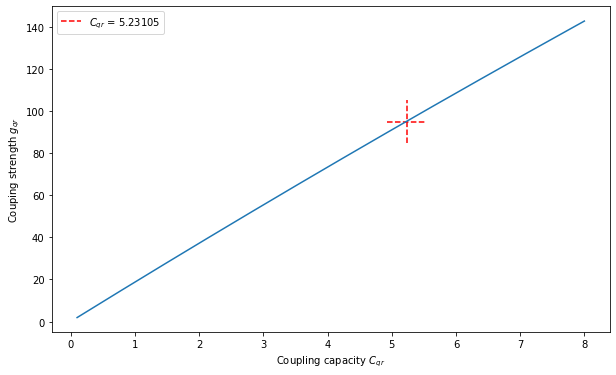

In [18]:
g_qr_plot(5.9, 7.2, 86, 95)

### 读出谐振腔与总线之间的耦合电容



# 量子比特的 dephasing 时间

对于Z线noise，造成比特频率间隔变化，即 $\omega_{01}$ 变化。
$$
T_{\phi}\approx \frac{\hbar}{A}\left|\frac{\partial E_{01}}{\partial\Phi}\right|^{-1}=\frac{\hbar}{A}\frac{\Phi_{0}}{\pi}\left(2E_{C}E_{J}^{max}\left|\sin\frac{\pi\Phi}{\Phi_{0}}\tan\frac{\pi\Phi}{\Phi_{0}}\right|\right)^{-1/2}
$$
在sweet spot点时，
$$
T_{\phi}=\left|\frac{\pi^{2}A^{2}}{\hbar}\frac{\partial^{2}E_{01}}{\partial \Phi^{2}}\right|^{-1}_{\Phi=0} = \frac{\hbar\Phi_{0}^{2}}{A^{2}\pi^{2}\sqrt{2E_{J}E_{C}}}
$$

In [21]:
C = 86
Ec = cn.e**2/(2*C*1e-15) 
Ejm = JR_N(0, 5.9, 86)[-1]
A = 1e-5

def Tphi_sweet(A, Ej, Ec):
    T = cn.hbar/(A**2 * np.pi**2 * np.sqrt(2*Ejm*Ec))
    return T*1e3

In [22]:
Tphi_sweet(1e-5, Ejm, Ec)

52.6535443130692

In [ ]:
Ec